----------------------------------------------------------------
## **<a class="anchor" id="link0">Problem 2: Player Categorization</a> 🎽**
----------------------------------------------------------------
**Date:** April 30, 2022</br>
**By:** Geoffrey Price</br>
</br>
In this notebook, I use cleaned data originally scraped from the AUDL website to assess the characteristics of different categories of players in the AUDL. I will use KNN and other methods to assign player positions to players who don't have a category on their website bio. 

**Problem Statement**
*How do players stats differ across different playing positions? Is there a set of stats that can be used to assign a position to players based on their performance?*</br>
The AUDL website places players into one of four categories:
- *Cutter:* A player who handles the disc less often and instead makes vertical and horizontal **cuts** on the field to help open up space or score
- *Defender:* A player who's skills are more oriented towards shutting down other teams' abilites to score
- *Handler:* A player who is skilled at identifying open players and throwing the disc to them.
- *Hybrid:* A player who has a combination of cutter and handler skills and is able to play in either position.

### Table of Contents
1. [Data Import and Overview 🧮](#link1)
2. [Univariate Analysis 1️⃣](#link2)
    - a. [Total Game Counts 🎮](#link2a)
    - b. [Goals Scored 🥅](#link2b)
    - c. [Univariate Analysis Summary](#link2c)
3. [Multivariate Analysis ✌➕](#link3)
    - a. [Correlation 📈](#link3a)
    - b. [Scores by Season 📅](#link3b)
    - c. [Margin of Victory 🤏](#link3c)
    - d. [Scoring Factor ➕➖](#link3d)
    - e. [Multivariate Analysis Summary](#link3e)
4. [Hypothesis Testing 👨🏿‍🔬](#link4)
5. [Conclusions 🔚](#link5)
    - a. [Data Limitations 📦](#link5a)
6. [Resources 🕸](#linkR)

In [1]:
# IMPORTS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

from icecream import ic

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

%matplotlib inline

# Theme
sns.set_theme(palette='Spectral')

# Color Palette
c_palette = {
    'unknown': '#8ecae6', #light blue
    'Defender': '#219ebc', #medium blue
    'Hybrid': '#023047', #dark blue
    'Handler': '#ffb703', #gold
    'Cutter': '#fb8500' #orange
}

-------------------------------------------------------------
# <a class="anchor" id="link0">Data Import and Overview</a> 🧮
-------------------------------------------------------------

In [2]:
# Data Import
DATA_PATH = ".\\DATA\\postproc\\players.csv"
odf: pd.DataFrame = pd.read_csv(DATA_PATH,)
odf.drop(labels=2161, axis=0, inplace=True) # known blank row
odf.head()


,player,games,points_played,off_possessions,scores,assists,goals,blocks,plus_minus,completions,...,hockey_assists,throwaways,stalls,drops,callahans,pulls,off_points_played,def_points_played,minutes_played,position
0,Cameron Brock,122,2631,2838,756,240,516,49,585,1644,...,146,177,0,43,0,6,2204,427,2123,Cutter
1,Cameron Harris,108,2361,2734,610,337,273,115,488,2035,...,180,198,1,39,0,132,1756,605,2117,Hybrid
2,Ben Jagt,79,1995,2194,525,254,271,115,485,1231,...,121,122,2,33,1,114,1202,793,2000,Hybrid
3,Jonathan Helton,110,2550,2288,609,362,247,147,458,2312,...,152,255,3,43,0,452,1738,812,1886,Hybrid
4,Keenan Plew,115,2429,2656,644,358,286,32,456,3584,...,213,179,1,41,1,5,2076,353,2022,Hybrid


In [3]:
# Dtypes and info
odf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2557 entries, 0 to 2557
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player             2557 non-null   object 
 1   games              2557 non-null   int64  
 2   points_played      2557 non-null   int64  
 3   off_possessions    2557 non-null   int64  
 4   scores             2557 non-null   int64  
 5   assists            2557 non-null   int64  
 6   goals              2557 non-null   int64  
 7   blocks             2557 non-null   int64  
 8   plus_minus         2557 non-null   int64  
 9   completions        2557 non-null   int64  
 10  completion_pct     1317 non-null   float64
 11  total_yards        2557 non-null   int64  
 12  throwing_yards     2557 non-null   int64  
 13  receiving_yards    2557 non-null   int64  
 14  off_efficiency     1574 non-null   float64
 15  hockey_assists     2557 non-null   int64  
 16  throwaways         2557 

### Summary:
- All category dtypes are correct. The only two 'object' categories are the player names and positions.
- `completion_pct`, `off_efficiency`, and `position` are the only three columns with null data.

----------------
# <a class="anchor" id="link2">Univariate Analysis 1️⃣</a>
----------------

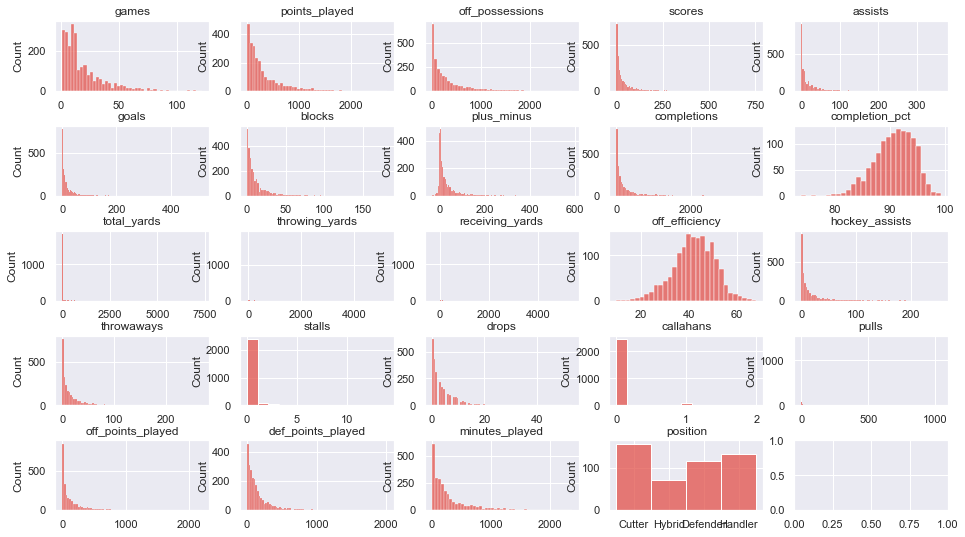

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

for col, ax in zip(odf.columns.drop('player'), ax.ravel()):
    sns.histplot(data=odf, x=col, ax=ax)

    # chart formatting
    ax.set_title(col)
    # ax.get_legend().remove()
    ax.set_xlabel("")

### Notes:
- Majority of distributions are heavily right skewed. indicating there are a lot of players who have relatively low stats in most categories. 
- The two distributions measuring efficiency (`off_efficiency` and `completion_pct`) are more normally distributed with some left skew
- Many stats have a very small number of players who have high numbers. These rare players have either been in the league a long time, or are incredibly good at getting certain stats.
- Given `games` and `points_played` follow similar distributions, for this analysis the majority of attributes will be normalized by `points_played`. Normalizing by `points_played` gives a more realistic visual of player performance based on opportunity and helps level out any players that have been playing for much longer.

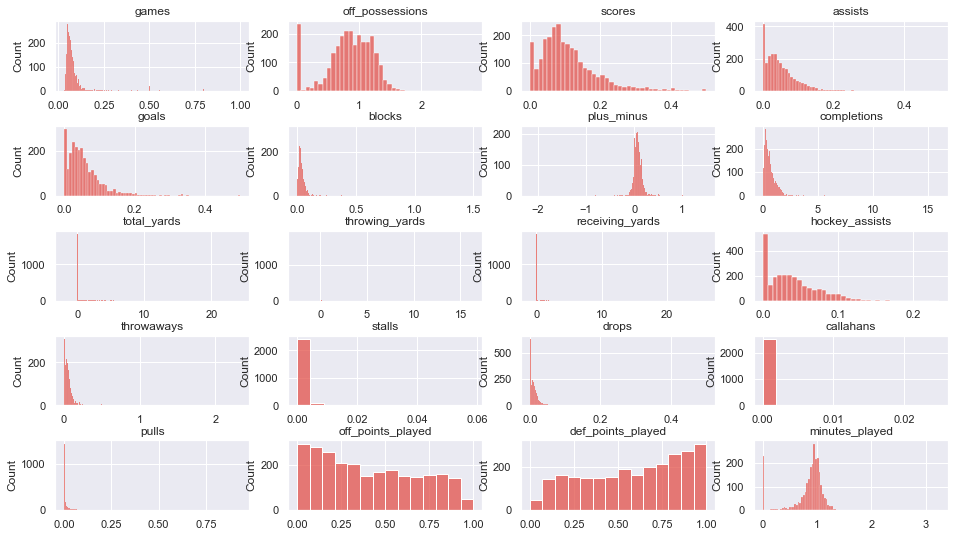

In [5]:
# Ignore percentage and categorical columns
cols_to_ignore = ['completion_pct', 'off_efficiency', 'position', 'player']
cols_to_keep = odf.columns.drop(labels=cols_to_ignore)

# Normalize by points played
norm_df = odf.loc[:, cols_to_keep].div(odf['points_played'], axis=0)

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

for col, ax in zip(norm_df.columns.drop(labels=['points_played']), ax.ravel()):
    sns.histplot(data=norm_df, x=col, ax=ax)

    # chart formatting
    ax.set_title(col)
    ax.set_xlabel("")


By normalizing by points played, the stats shown are more indicative of skill level when compared to other values. More points played = more opportunity and, without normalizing, players who've played more games/points will appear to be better in comparison to others who have not.

There are a lot of stats that show a high value count of '0' for that stat. This could be a select set of players who don't have very high stats. The subset of players  with 0 completions is analyzed below.

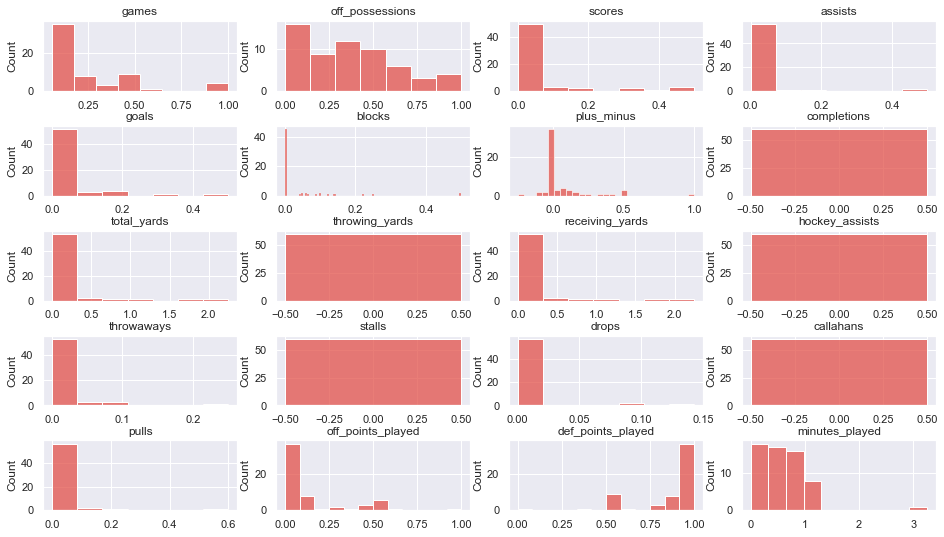

In [6]:
zero_comp = norm_df[norm_df['completions'] == 0]

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

for col, ax in zip(zero_comp.columns.drop(labels=['points_played']), ax.ravel()):
    sns.histplot(data=zero_comp, x=col, ax=ax)

    # chart formatting
    ax.set_title(col)
    ax.set_xlabel("")

There are 60 players who are noted as having no completions. This is suspicious because it's almost impossible to play multiple points in ultimate and not throw the disc to someone else for a single completion.

These 60 players account for 7 labeled players:
- 3 cutters
- 2 handlers
- 1 defender, and
- 1 hybrid

For now, all 60 entries will be kept in the data set.

In [7]:
#HOUSE CLEANING
del ax, col, fig, zero_comp

-------------------------------
# <a class="anchor" id="link3">Multivariate Analysis ✌🏿➕</a>
-------------------------------

## Correlation Heatmap

In [8]:
# Re-add columns removed for normalization & fill na for position with 'unknown'
norm_df[cols_to_ignore] = odf[cols_to_ignore]
norm_df['position'] = norm_df['position'].fillna('unknown')

unknown = norm_df[norm_df['position'] == 'unknown']
norm_df = norm_df[norm_df['position'] != 'unknown']

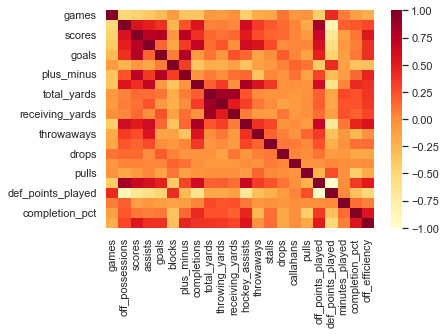

In [9]:
# Correlation Matrix
corr_df = norm_df.drop(labels='points_played', axis=1).corr()
sns.heatmap(corr_df, cmap='YlOrRd');

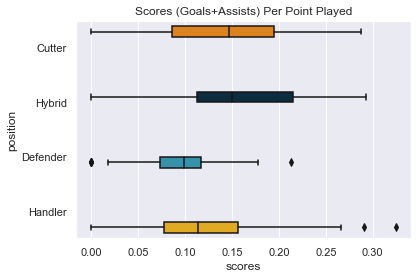

In [10]:
sns.boxplot(data=norm_df, x='scores', y='position', hue='position', palette=c_palette)
plt.title('Scores (Goals+Assists) Per Point Played')
plt.legend().remove()

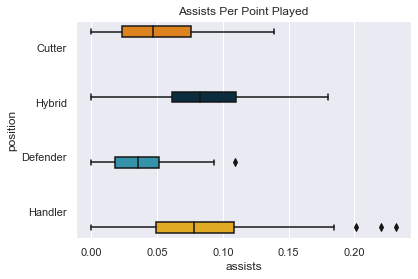

In [11]:
sns.boxplot(data=norm_df, x='assists', y='position', hue='position', palette=c_palette)
plt.title('Assists Per Point Played')
plt.legend().remove()

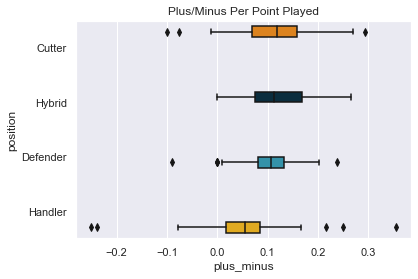

In [12]:
# Plus/Minus - 'Unknown' category removed due to high number of outliers
sns.boxplot(data=norm_df, 
            x='plus_minus', y='position', 
            hue='position', palette=c_palette)
plt.title('Plus/Minus Per Point Played')
plt.legend().remove()

In [13]:
# Pairplot 
# sns.pairplot(data=norm_df[norm_df['position'] != 'unknown'].drop(labels='points_played', axis=1), 
#              hue='position', 
#              palette=c_palette, 
#              corner=True);

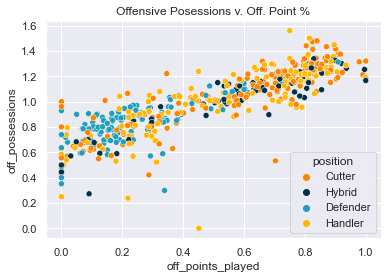

In [14]:
sns.scatterplot(data=norm_df, 
                x='off_points_played', 
                y='off_possessions', 
                hue='position',
                palette=c_palette);
plt.title('Offensive Posessions v. Off. Point %');

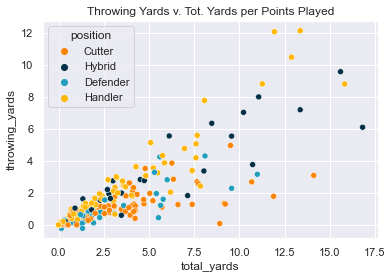

In [15]:
sns.scatterplot(data=norm_df[norm_df['position'] != 'unknown'], 
                x='total_yards', 
                y='throwing_yards', 
                hue='position',
                palette=c_palette);
plt.title('Throwing Yards v. Tot. Yards per Points Played');

### Notes:

**Correlation Matrix**
- High correlation between throwing_yards, total_yards, and receiving_yards
- High correlation between completions and throwaways
- High correlation between offensive possesions, hockey_assists, and minutes_played

Given several areas of high correlation, it is in good interest to remove several columns before creating a model to predict position. Later in the notebook, VIF will be used to reduce collinearity.

**Pairplot**
- The shown pairplot indicates good segmentation between certain classes like handler and cutter. The 'unknown' category is not included because the majority of players are 'unknown' and it makes it more difficult to see patterns among the already labeled data points.

**Scatter Plots**
- Although there is some existing division among players, the differences among the player categories is not fully apparent.

**Conclusion**
In the next section, the following steps are taken to further prepare the data for various forms of supervised learning.
- *Scaling* - Done to get all data points on similar scales so larger values of data (i.e. `minutes_played`, `total_yards`, etc.) are not more heavily weighted by any models.
- *Removing Collinearity* - Collinearity reduces the models capacity to correctly make predictions. I use variance inflation factor (VIF) in a guess-check-revise system to remove columns and reduce collinearity.

----------
# Scaling & Check for Collinearity
----------

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [17]:
# Scale and sample
temp = norm_df.drop(labels=['position', 'player'], axis=1).copy(deep=True)
scaler: StandardScaler = StandardScaler()
scaler.fit(temp)
scaled_array = scaler.transform(temp)

scaled_df = pd.DataFrame(scaled_array, 
                         columns=[i for i in norm_df.columns if i not in ['position', 'player']],
                         index=temp.index
)
scaled_df = scaled_df.drop(labels='points_played', axis=1)

In [18]:
scaled_df.sample(5, random_state=92)

,games,off_possessions,scores,assists,goals,blocks,plus_minus,completions,total_yards,throwing_yards,...,throwaways,stalls,drops,callahans,pulls,off_points_played,def_points_played,minutes_played,completion_pct,off_efficiency
40,-0.780568,0.846944,1.405572,1.443759,0.719126,-0.522737,1.086474,1.302330,0.943027,1.169644,...,0.124305,-0.057109,-0.120277,-0.254242,-0.503050,1.104194,-1.104194,0.187228,1.102986,1.562060
656,-0.345751,0.222324,-0.399309,0.273177,-0.866666,-1.044867,-1.062153,1.505598,-0.472891,-0.345890,...,0.625606,1.400948,0.102476,-0.254242,-0.423500,0.905328,-0.905328,-0.885643,0.706420,0.129606
132,-0.524517,1.103124,1.152463,1.036797,0.732095,-0.297576,0.472429,-0.045418,-0.612939,-0.516260,...,0.721493,0.080827,0.727378,-0.254242,-0.154630,0.675638,-0.675638,-0.101449,-1.226097,-0.444186
34,-0.405090,0.724705,1.422895,1.362740,0.823769,-0.217648,0.926430,-0.231846,0.437939,0.182935,...,0.610355,0.284986,-0.046382,-0.254242,-0.317404,0.627490,-0.627490,0.281750,-1.276408,0.607541
144,-0.372196,0.109036,0.417869,-0.409746,1.027019,-0.276075,0.622576,-0.555260,-0.517933,-0.469094,...,-0.560120,-0.490393,-0.134713,-0.254242,-0.549081,-0.066721,0.066721,0.220270,0.105653,-0.133663


In [19]:
# Create dataframe for VIF values of each column
vif_data = scaled_df[[i for i in scaled_df.columns if i not in cols_to_ignore]]
vif_values = pd.DataFrame()

vif_values['Attribute'] = vif_data.columns
vif_values['VIF'] = [variance_inflation_factor(vif_data.values, i) for i in range(len(vif_data.columns))]
vif_values

c:\Users\Geoffrey\Documents\GitHub\audl_ds\.venv3.9.4\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Attribute,VIF
0,games,1.754401
1,off_possessions,6.497313
2,scores,inf
3,assists,inf
4,goals,inf
5,blocks,inf
6,plus_minus,inf
7,completions,6.102118
8,total_yards,inf
9,throwing_yards,inf


In [20]:
# After some trial and error, final list of removed columns
drop_cols = [
             'points_played', # 1 for all given normalization
             'goals', # linear combination of scores and assists
             'scores',  # likely high correlation with assists
             'total_yards',  # linear combination of throwing_yards and receiving_yards
             'def_points_played',  # 1 - off_points_played
             'completion_pct', # heavily correlated with another value
             'off_efficiency' # ???
             ]

vif_data = scaled_df[[i for i in scaled_df.columns if i not in drop_cols]]
vif_values = pd.DataFrame()

vif_values['Attribute'] = vif_data.columns
vif_values['VIF'] = [variance_inflation_factor(vif_data.values, i) for i in range(len(vif_data.columns)) ]
vif_values

,Attribute,VIF
0,games,1.754401
1,off_possessions,6.497313
2,assists,6.059911
3,blocks,2.883678
4,plus_minus,6.762477
5,completions,6.102118
6,throwing_yards,1.853025
7,receiving_yards,1.728077
8,hockey_assists,4.209795
9,throwaways,4.851218


**NOTES:**
- Seven total columns were removed to reduce collinearity. Often these columns were linear combinations of other columns (e.g. `goals` and `scores` linearly combined to be `assists`).
- Other columns were percentages (e.g. `completion_pct`, and `off_efficiency`) which were typically highly correlated with other values.
- The final dataframe shows VIF values all <10 which indicates collinearity has been significantly reduced.

------------
# Data Prep for Modeling
------------

In [21]:
# Separate Independant and Dependant
y = norm_df['position'].astype('category')
X = vif_data.copy(deep=True)

y_labels = y.unique()
idx2class = {}
class2idx = {}

i = 0

# For quick conversions
for label in y_labels:
    idx2class[i] = label
    class2idx[label] = i

    i+=1

y = y.replace(to_replace=class2idx)

In [50]:
# Train / Test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=92, stratify=y)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (331, 16)
X_test shape: (143, 16)
y_train shape: (331,)
y_test shape: (143,)


-----------------------
# PCA
-----------------------

In [23]:
# Create PCA obj based on X_train data
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [24]:
# Explained variance ratio based on the two created principle components
print(f"The explained variance ratios using raw data is {pca.explained_variance_ratio_}")

The explained variance ratios using raw data is [0.28217088 0.11813786]


In [25]:
# Create dataframe for new PCA data for plotting
X_train_pca_labeled = pd.DataFrame(X_train_pca, columns=['x1','x2'], index=X_train.index)
X_train_pca_labeled = X_train_pca_labeled.merge(right=odf['position'].fillna('unknown'), how='left', left_index=True, right_index=True)
X_train_pca_labeled.sample(4, random_state=92)

,x1,x2,position
256,-1.136213,-0.218958,Hybrid
384,-1.000287,-0.302632,Hybrid
699,-3.447288,0.702430,Handler
474,-1.590036,0.209168,Handler


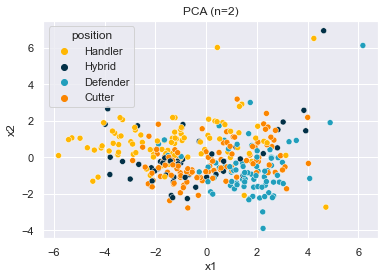

In [26]:
sns.scatterplot(data=X_train_pca_labeled[X_train_pca_labeled['position'] != 'unknown'], x='x1', y='x2', hue='position', palette=c_palette)
plt.title('PCA (n=2)');

*NOTES:*
- PCA overall explains roughly 40% of the total variance. This is good but not ideal and therefore wouldn't be suitable for trying to predict or assign labels
- The scatterplot shows a decent amount of segmentation. Defenders especially are almost exclusively in the lower-right quadrant of the graph, Cutters primarily have an X2 value of <0 until X1 is >0
- Handlers are primarily in the upper-left collection of points.
- As expected, hybrid players seem to be very spread and cover areas primarily covered by Handlers and Cutters (but not Defenders)


In [27]:
# Create a dataframe of X_train with proper labels for K Means and KNN
X_train_labels: pd.DataFrame = X_train.merge(right=norm_df['position'], how='left', left_index=True, right_index=True)

# Final databases to be used in models.
model_df = X_train_labels.drop(labels='position', axis=1)
model_y = X_train_labels['position'].replace(to_replace=class2idx)

---------------------------
# <a class="anchor" id="linkLR">KNN</a>
---------------------------

In [31]:
# IMPORTS
# from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors, NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn import metrics

c:\Users\Geoffrey\Documents\GitHub\audl_ds\.venv3.9.4\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


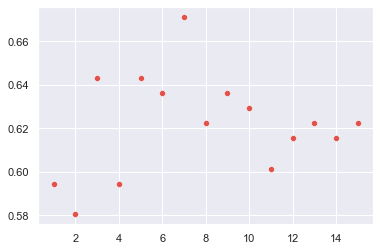

In [32]:
n = 15
score = []
for i in range(1,n+1):
    neighbors = KNeighborsClassifier(n_neighbors=i)
    nca = NeighborhoodComponentsAnalysis(random_state=92)

    nca_pipe = Pipeline([('nca', nca), ('knn', neighbors)])
    nca_pipe = nca_pipe.fit(model_df, model_y)
    score.append(nca_pipe.score(X_test, y_test))

sns.scatterplot([i for i in range(1, n+1)], score);

- In a KNN Classifier, the optimal number of neighbors appears to be 7 when looking at k<=15

In [33]:
kneighbors = KNeighborsClassifier(n_neighbors=7,
                                  weights='uniform',
                                  algorithm='auto',
                                  n_jobs=-1
                                  )
nca_pipe = Pipeline([('nca', nca), ('knn', kneighbors)])
nca_pipe = nca_pipe.fit(X_train, y_train)

y_hat = nca_pipe.predict(X_test)

metrics.f1_score(y_true=y_test, 
                 y_pred=y_hat,
                 average='micro')

0.6713286713286714

In [49]:
get_metrics_score(kneighbors, flag=False)

c:\Users\Geoffrey\Documents\GitHub\audl_ds\.venv3.9.4\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Geoffrey\Documents\GitHub\audl_ds\.venv3.9.4\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Geoffrey\Documents\GitHub\audl_ds\.venv3.9.4\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Geoffrey\Documents\GitHub\audl_ds\.venv3.9.4\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


[0.2719033232628399,
 0.2867132867132867,
 0.2719033232628399,
 0.2867132867132867,
 0.2719033232628399,
 0.2867132867132867,
 0.2719033232628399,
 0.2867132867132867]

| model | f-1 score |
|-------|-----------|
|  KNN  | 0.67133   |

------------
# MODELING
------------

In [47]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    train_recall = metrics.recall_score(y_train,pred_train, average='micro')
    test_recall = metrics.recall_score(y_test,pred_test, average='micro')
    
    train_precision = metrics.precision_score(y_train,pred_train, average='micro')
    test_precision = metrics.precision_score(y_test,pred_test, average='micro')
    
    train_f1 = f1_score(y_train,pred_train, average='micro')
    test_f1 = f1_score(y_test,pred_test, average='micro')
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision, train_f1, test_f1))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
        print("F1-Score on training set : ",metrics.f1_score(y_train,pred_train))
        print("F1-Score on test set : ",metrics.f1_score(y_test,pred_test))
    
    return score_list # returning the list with train and test scores

--------------------------
# Decision Tree
--------------------------

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [ ]:
dt_model = DecisionTreeClassifier(criterion='gini', 
                                  random_state=92,
                                  splitter='best',
                                  max_depth=5
                                  )
dt_model.fit(model_df, model_y)

In [ ]:
get_metrics_score(dt_model, flag=True)

In [ ]:
feature_names = list(X_train.columns)
plt.figure(figsize=(20,30))

out = tree.plot_tree(dt_model,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
for o in out:
     arrow = o.arrow_patch
     if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [ ]:
importances = dt_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Choose the type of classifier. 
estimator = DecisionTreeClassifier(random_state=92)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(4,11), 
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [5, 10,15,20,25,30],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Run the grid search
grid_obj = GridSearchCV(estimator, 
                        parameters,
                        scoring='f1_micro',
                        cv=5)

grid_obj = grid_obj.fit(model_df, model_y)

# Set the clf to the best combination of parameters
estimator: grid_obj.best_estimator_ = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
estimator.fit(model_df, model_y)

In [ ]:
# Check Results
estimator.score(X=X_test, y=y_test)

-------------
# Random Forest
-------------

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Choose the type of classifier. 
estimator = RandomForestClassifier(random_state=92)

# Grid of parameters to choose from
parameters = {'n_estimators': np.arange(10, 100, 10),
              'max_features': ['sqrt','log2',None],
              'min_samples_leaf': np.arange(1,15,5),
              'min_samples_split': np.arange(2, 20, 5),
             }

# Run the grid search
grid_obj = GridSearchCV(estimator, 
                        parameters,
                        scoring='f1_micro',
                        cv=5)

grid_obj = grid_obj.fit(model_df, model_y)

# Set the clf to the best combination of parameters
rf_estimator: grid_obj.best_estimator_ = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_estimator.fit(model_df, model_y)

In [ ]:
y_hat = rf_estimator.predict(X_test)
metrics.f1_score(y_true=y_test, 
                 y_pred=y_hat,
                 average='micro')

----------------
# XGBoost
----------------

In [ ]:
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=92, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters, scoring='f1_micro', cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

In [ ]:
y_hat = xgb_tuned.predict(X_test)
metrics.f1_score(y_true=y_test, 
                 y_pred=y_hat,
                 average='micro')

| model | f-1 score |
|-------|-----------|
| Decision Tree | 0.559944 |
| Random Forest | 0.60839 |
|  XGB  | 0.64336 |
|  KNN  | 0.67133   |

--------
# Ensemble
--------

---------------------------
# <a class="anchor" id="linkR">Resources 🕸</a>
---------------------------
1. [The AUDL Website](https://theaudl.com/)
2. ['AUDL 2019: Closer than Ever'](https://theaudl.com/league/news/2019-audl-closer-ever-competition)
3. ['AUDL Announces 2022 Schedule, Championship Weekend Back in Madison](https://ultiworld.com/2022/02/21/audl-announces-2022-schedule-championship-weekend-back-in-madison/#:~:text=Along%20with%20the%20return%20of,Lake%20Shred%2C%20and%20Colorado%20Summit)

In [ ]:
### DATA NOTES:
- It's very possible for players to switch positions as they progress. Unfortunately the labeled data for players is not by season. If a player switches from cutter to handler, and they are labeled as a handler, their stats likely aren't fully indicative of a typical handler's stats.
- Assumption: The labeled players are a good representation of a random selection of players with significant playtime from the league.
- The quantity and quality of data collected has improved significantly as the AUDL has had more and more seasons.